# Basic init code

## Imports

In [153]:
import os, shutil, warnings, torch, json
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, F1Score
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

## User Defintion Area

In [154]:
# Custom Name to give to the trained model
customName = "DepressionSave"

file_loc = r"C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Intent Training\balanced_dataset.csv"
# "C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Conversational Training\Intent Based\Small_talk_Intent.csv"

# Name of the folder to be used as a root, for saving model and for running from it
ds_folder = r"C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\scripts\training\Intent Recognition\Results"

# model name to fine tune on
model_name = "distilbert/distilbert-base-uncased" 

# Name of the files that are saved in the end, and used again
train_file_custom_name = r"C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Intent Training\Intermediatory Saves\train.csv"
val_file_custom_name = r"C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Intent Training\Intermediatory Saves\val.csv"
test_file_custom_name = r"C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Intent Training\Intermediatory Saves\test.csv"

className = "label" # Usually with the name "Intent", depends file to file
gpuMode = 'cuda' # 'cpu'

epochs = 80
learningRate = 1e-5 # 1e-5, 2e-5(wasn't as good), 3e-5

## Dataset Separation

In [155]:
# Load the dataset
dataset = pd.read_csv(file_loc)

# Split the dataset into training and temporary datasets
train_data, temp_data = train_test_split(dataset, test_size=0.4, random_state=42)

# Split the temporary dataset into validation and test datasets
val_data, test_data = train_test_split(temp_data, test_size=0.4, random_state=42)

# Save the datasets to separate files
save_loc = ds_folder

train_data.to_csv(os.path.join(save_loc, train_file_custom_name), index=False)
val_data.to_csv(os.path.join(save_loc, val_file_custom_name), index=False)
test_data.to_csv(os.path.join(save_loc, test_file_custom_name), index=False)

print("Datasets have been split and saved successfully.")

Datasets have been split and saved successfully.


### Conversion of nulls to pre-defined entries

In [156]:
if customName == "":
    customName = "savedModel"

if ds_folder == "":
    ds_folder = r'C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Conversational Training\Intent Based\difDs'

if model_name == "":
    model_name = "distilbert/distilbert-base-uncased" 

if train_file_custom_name == "":
    train_file_custom_name = 'train.csv'

if val_file_custom_name == "":
    train_file_custom_name = 'val.csv'

if test_file_custom_name == "":
    train_file_custom_name = 'test.csv'

if learningRate == "":
    learningRate = "1e-5"

## Dependancy Definition

In [157]:
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

warnings.filterwarnings("ignore")

trainfile = os.path.join(ds_folder, train_file_custom_name)
validfile = os.path.join(ds_folder, val_file_custom_name)
testfile = os.path.join(ds_folder, test_file_custom_name)

traindf = pd.read_csv(trainfile)
validdf = pd.read_csv(validfile)
testdf = pd.read_csv(testfile)

## Model Download

In [158]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Feature Definition and Graph Plotting

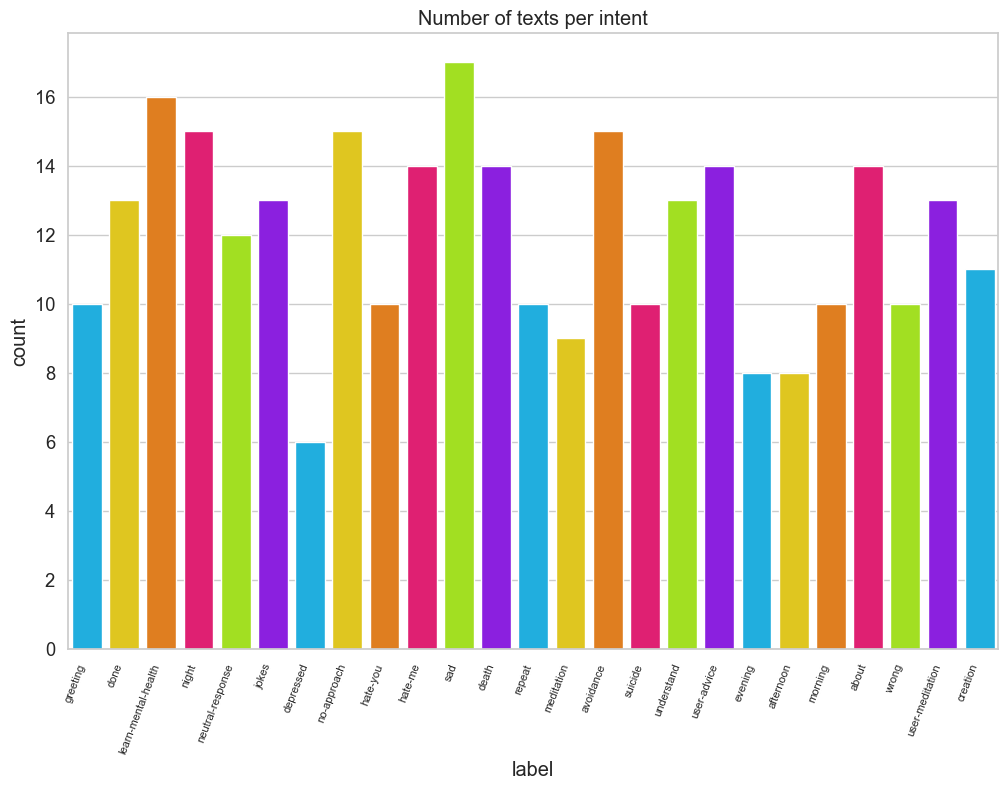

In [159]:
trainfeatures = traindf.copy()
trainlabels = trainfeatures.pop(className)

testfeatures = testdf.copy()
testlabels = testfeatures.pop(className)

validfeatures = validdf.copy()
validlabels = validfeatures.pop(className)

chart = sns.countplot(x=trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=69, horizontalalignment='right', fontsize=8)

# Get the x-axis entries
x_axis_entries = [tick.get_text() for tick in chart.get_xticklabels()]
len_dims = len(x_axis_entries)

In [160]:
label_encoder = LabelEncoder()

trainlabels = label_encoder.fit_transform(trainlabels.values)
testlabels = label_encoder.transform(testlabels.values)
validlabels = label_encoder.transform(validlabels.values)

# Core AI Code

## Model Definition

In [161]:
class IntentClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(IntentClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits

num_labels = len_dims
model = IntentClassifier(model_name, num_labels).to(gpuMode)

def prepare_data(features, labels):
    features = [str(feature) for feature in features]
    features = tokenizer(features, padding=True, truncation=True, return_tensors="pt")
    
    labels = torch.tensor(labels).long().to(gpuMode)  # Change to long tensor
    
    dataset = TensorDataset(features['input_ids'], features['attention_mask'], labels)
    return dataset

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
# Prepare train, validation, and test datasets
train_dataset = prepare_data(trainfeatures.values, trainlabels)
valid_dataset = prepare_data(validfeatures.values, validlabels)
test_dataset = prepare_data(testfeatures.values, testlabels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label classification
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=2e-5)
optimizer = optim.Adam(model.parameters(), lr=learningRate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# accuracy = Accuracy(task='binary').to('cuda') 
# accuracy = Accuracy(task='multiclass', num_classes=num_labels, average='micro').to('cuda') 
accuracy = Accuracy(task='multiclass', num_classes=num_labels).to(gpuMode) 
f1_score = F1Score(task='multiclass', num_classes=num_labels, average='macro').to(gpuMode)

## Main training loop

In [163]:
if gpuMode == 'cuda':
    model.cuda()
elif gpuMode == 'cpu':
    model.cpu()

train_losses, train_accuracies, train_f1_scores, val_losses, val_accuracies, val_f1_scores = [], [], [], [], [], []

for epoch in range(epochs):

    model.train()
    total_loss = 0
    total_accuracy = 0
    total_f1 = 0 

    for batch in train_loader:

        input_ids, attention_mask, labels = [x.to(gpuMode) for x in batch] 

        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        total_accuracy += accuracy(logits, labels)
        total_f1 += f1_score(logits, labels)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    train_f1_scores.append(avg_f1)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_accuracy:.4f}, Training F1: {avg_f1:.4f}")

    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [x.to(gpuMode) for x in batch]

            logits = model(input_ids, attention_mask=attention_mask)

            val_loss = loss_fn(logits, labels)
            total_val_loss += val_loss.item()
            total_val_accuracy += accuracy(logits, labels)
            total_val_f1 += f1_score(logits, labels)

    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_accuracy = total_val_accuracy / len(valid_loader)
    avg_val_f1 = total_val_f1 / len(valid_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    val_f1_scores.append(avg_val_f1)

    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {avg_val_accuracy:.4f}, Validation F1: {avg_val_f1:.4f}")

Epoch 1/80
Training loss: 3.2198, Training accuracy: 0.0688, Training F1: 0.0291
Validation loss: 3.2074, Validation accuracy: 0.0677, Validation F1: 0.0302
Epoch 2/80
Training loss: 3.1913, Training accuracy: 0.0729, Training F1: 0.0346
Validation loss: 3.2073, Validation accuracy: 0.0573, Validation F1: 0.0268
Epoch 3/80
Training loss: 3.1698, Training accuracy: 0.0854, Training F1: 0.0514
Validation loss: 3.2036, Validation accuracy: 0.0156, Validation F1: 0.0087
Epoch 4/80
Training loss: 3.1232, Training accuracy: 0.1479, Training F1: 0.0958
Validation loss: 3.1798, Validation accuracy: 0.0521, Validation F1: 0.0506
Epoch 5/80
Training loss: 3.0770, Training accuracy: 0.2125, Training F1: 0.1220
Validation loss: 3.1419, Validation accuracy: 0.0781, Validation F1: 0.0783
Epoch 6/80
Training loss: 3.0066, Training accuracy: 0.2708, Training F1: 0.1699
Validation loss: 3.0875, Validation accuracy: 0.1875, Validation F1: 0.1510
Epoch 7/80
Training loss: 2.9305, Training accuracy: 0.330

### Saving the model

In [164]:
import torch

saved_model_name = f"{customName}_{epochs}_{avg_val_accuracy:.4f}.pth"

torch.save(model.state_dict(), saved_model_name)

print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {avg_val_accuracy:.4f}, Validation F1: {avg_val_f1:.4f}")
print(f"Model saved to {saved_model_name}")

Validation loss: 1.6522, Validation accuracy: 0.5755, Validation F1: 0.4949
Model saved to DepressionSave_80_0.5755.pth


## Plotting Accuracy, F1, Loss

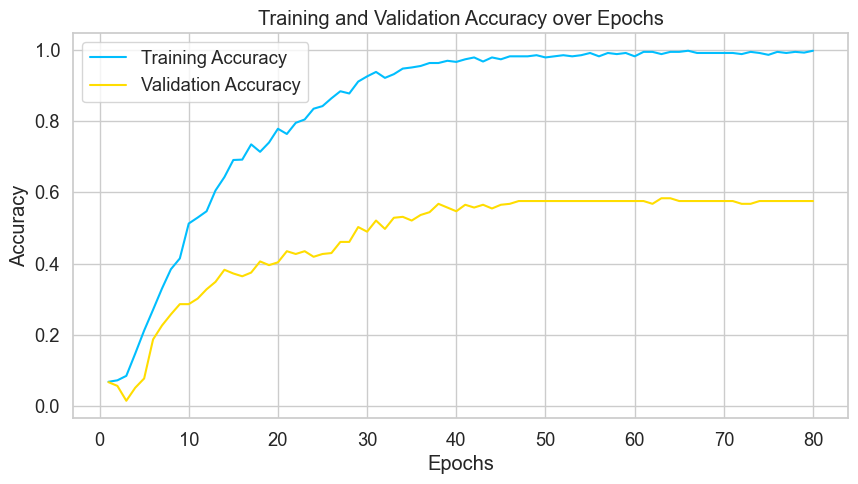

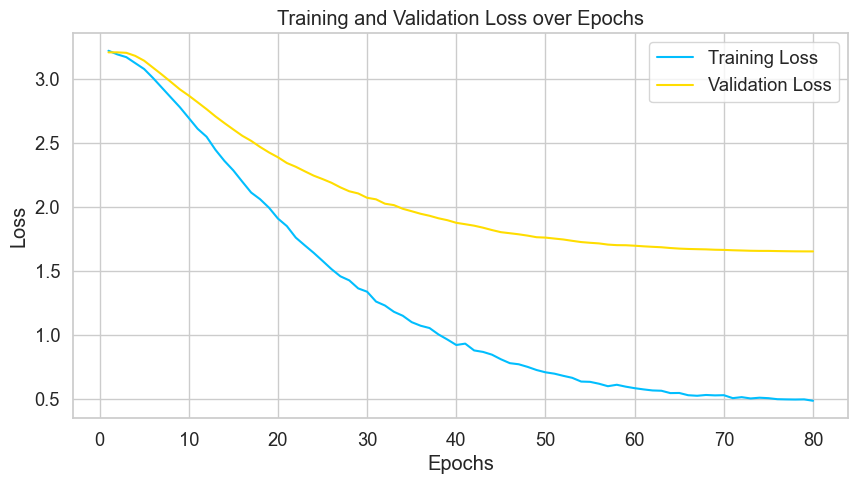

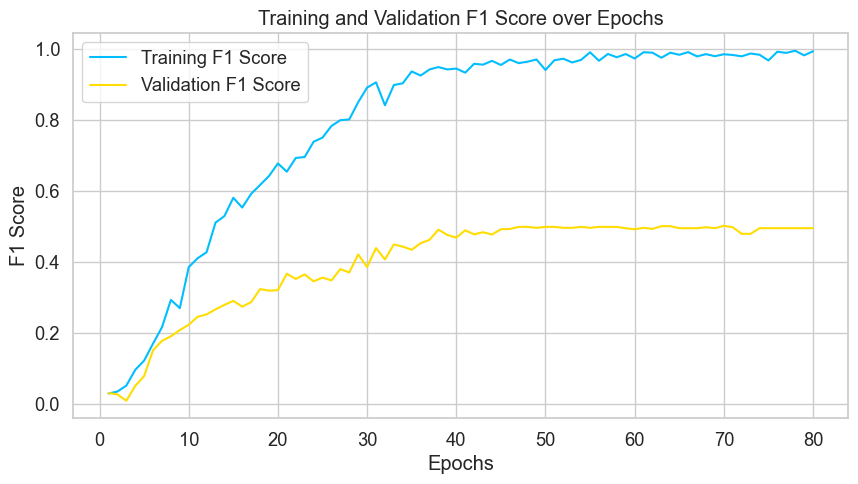

Plots have been saved as 'accuracy_plot_80_0.5755.png', 'loss_plot_80_0.5755.png', and 'f1_score_plot_80_0.5755.png'


In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays
train_accuracies_np = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies_np = [acc.cpu().numpy() for acc in val_accuracies]
train_losses_np = train_losses  # These should already be float values
val_losses_np = val_losses  # These should already be float values
train_f1_scores_np = [f1.cpu().numpy() for f1 in train_f1_scores]
val_f1_scores_np = [f1.cpu().numpy() for f1 in val_f1_scores]

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies_np, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies_np, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(f'accuracy_plot_{epochs}_{avg_val_accuracy:.4f}.png')
# plt.close()
plt.show()

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_np, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses_np, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(f'loss_plot_{epochs}_{avg_val_accuracy:.4f}.png')
# plt.close()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_f1_scores_np, label='Training F1 Score')
plt.plot(range(1, epochs + 1), val_f1_scores_np, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(f'f1_score_plot_{epochs}_{avg_val_accuracy:.4f}.png')
# plt.close()
plt.show()

print(f"Plots have been saved as 'accuracy_plot_{epochs}_{avg_val_accuracy:.4f}.png', 'loss_plot_{epochs}_{avg_val_accuracy:.4f}.png', and 'f1_score_plot_{epochs}_{avg_val_accuracy:.4f}.png'")

## Model Testing / Evaluation

In [166]:
# Testing the Model
model.eval()

total_test_loss = 0
total_test_accuracy = 0
total_test_f1 = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(gpuMode) for x in batch]

        logits = model(input_ids, attention_mask=attention_mask)

        test_loss = loss_fn(logits, labels)
        total_test_loss += test_loss.item()
        total_test_accuracy += accuracy(logits, labels)
        total_test_f1 += f1_score(logits, labels)

avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)
avg_test_f1 = total_test_f1 / len(test_loader)

print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {avg_test_accuracy:.4f}, Test F1: {avg_test_f1:.4f}")

Test loss: 1.8476, Test accuracy: 0.4896, Test F1: 0.3759


## Inference Code

In [170]:
def predict_intent(text, model, tokenizer, label_encoder, device):
    # Prepare the input
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask)

    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert the predicted class back to the original label
    predicted_intent = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_intent

# Load the saved model
model = IntentClassifier(model_name, num_labels)
model.load_state_dict(torch.load(saved_model_name))
model.to(gpuMode)

# Example usage
text = "How should I deal with depression ?"
predicted_intent = predict_intent(text, model, tokenizer, label_encoder, gpuMode)
print(f"The predicted intent for '{text}' is: {predicted_intent}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The predicted intent for 'How should I deal with depression ?' is: learn-mental-health
